# Amazon SageMaker Object Detection Incremental Training

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
  1. [Download data](#Download-data)
  2. [Convert data into RecordIO](#Convert-data-into-RecordIO)
  3. [Upload data to S3](#Upload-data-to-S3)
4. [Intial Training](#Initial-Training)
5. [Incremental Training](#Incremental-Training)
6. [Hosting](#Hosting)
7. [Inference](#Inference)

## Introduction

In this example, we will show you how to train an object detector by re-using a model you previously trained in the SageMaker. With this model re-using ability, you can save the training time when you update the model with new data or improving the model quality with the same data. In the first half of this notebook ([Intial Training](#Initial-Training)), we will follow the [training with RecordIO format example](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) to train a object detection model on the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/). In the second half, we will show you how you can re-use the trained model and improve its quality without repeating the entire training process.

## Setup

To train the Object Detection algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with we need an AWS account role with SageMaker access. This role is used to give SageMaker access to your data in S3 will automatically be obtained from the role used to start the notebook.

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::217780494771:role/service-role/AWSGlueServiceSageMakerNotebookRole-job-testing
CPU times: user 1.08 s, sys: 466 ms, total: 1.55 s
Wall time: 778 ms


We also need the S3 bucket that you want to use for training and to store the tranied model artifacts. In this notebook, we require a custom bucket that exists so as to keep the naming clean. You can end up using a default bucket that SageMaker comes with as well.

In [2]:
bucket = sess.default_bucket() # Use the default bucket. You can also customize bucket name.
prefix = 'DEMO-ObjectDetection'

Lastly, we need the Amazon SageMaker Object Detection docker image, which is static and need not be changed.

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


## Data Preparation
[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) was a popular computer vision challenge and they released annual challenge datasets for object detection from 2005 to 2012. In this notebook, we will use the data sets from 2007 and 2012, named as VOC07 and VOC12 respectively. Cumulatively, we have more than 20,000 images containing about 50,000 annotated objects. These annotated objects are grouped into 20 categories.

While using the Pascal VOC dateset, please be aware of the database usage rights:
"The VOC data includes images obtained from the "flickr" website. Use of these images must respect the corresponding terms of use: 
* "flickr" terms of use (https://www.flickr.com/help/terms)"

### Download data
Let us download the Pascal VOC datasets from 2007 and 2012.

In [4]:
%%time

# Download the dataset
!wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
# # Extract the data.
!tar -xf /tmp/VOCtrainval_11-May-2012.tar && rm /tmp/VOCtrainval_11-May-2012.tar
!tar -xf /tmp/VOCtrainval_06-Nov-2007.tar && rm /tmp/VOCtrainval_06-Nov-2007.tar
!tar -xf /tmp/VOCtest_06-Nov-2007.tar && rm /tmp/VOCtest_06-Nov-2007.tar

--2021-02-10 12:35:27--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘/tmp/VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  14.1MB/s    in 2m 18s  

2021-02-10 12:37:46 (13.8 MB/s) - ‘/tmp/VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

--2021-02-10 12:37:46--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘/tmp/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov

### Convert data into RecordIO
[RecordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) is a highly efficient binary data format from [MXNet](https://mxnet.incubator.apache.org/) that makes it easy and simple to prepare the dataset and transfer to the instance that will run the training job. To generate a RecordIO file, we will use the tools from MXNet. The provided tools will first generate a list file and then use the [im2rec tool](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) to create the [RecordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) file. More details on how to generate RecordIO file for object detection task, see the [MXNet example](https://github.com/apache/incubator-mxnet/tree/master/example/ssd).

We will combine the training and validation sets from both 2007 and 2012 as the training data set, and use the test set from 2007 as our validation set.

In [5]:
!python tools/prepare_dataset.py --dataset pascal --year 2007,2012 --set trainval --target VOCdevkit/train.lst
!rm -rf VOCdevkit/VOC2012
!python tools/prepare_dataset.py --dataset pascal --year 2007 --set test --target VOCdevkit/val.lst --no-shuffle
!rm -rf VOCdevkit/VOC2007

saving list to disk...
List file VOCdevkit/train.lst generated...
Creating .rec file from /home/ec2-user/SageMaker/object_detection_pascalvoc_coco_2021-01-28/VOCdevkit/train.lst in /home/ec2-user/SageMaker/object_detection_pascalvoc_coco_2021-01-28/VOCdevkit
time: 0.1774766445159912  count: 0
time: 1.8621563911437988  count: 1000
time: 2.12064266204834  count: 2000
time: 2.195976734161377  count: 3000
time: 2.01200795173645  count: 4000
time: 2.156205654144287  count: 5000
time: 1.9907631874084473  count: 6000
time: 2.018601655960083  count: 7000
time: 2.2220757007598877  count: 8000
time: 2.0684807300567627  count: 9000
time: 2.181593179702759  count: 10000
time: 2.0375747680664062  count: 11000
time: 2.0028278827667236  count: 12000
time: 2.025526762008667  count: 13000
time: 2.0002715587615967  count: 14000
time: 2.0329270362854004  count: 15000
time: 2.03999400138855  count: 16000
Record file VOCdevkit/train.rec generated...
saving list to disk...
List file VOCdevkit/val.lst genera

Along with this notebook, we have provided tools that can directly generated the RecordIO files so that you do not need to do addtional work. These tools work with the Pascal datasets lst format, which is also quite the common among most datasets. If your data are stored in a different format or the annotation of your data is in a different format than the Pascal VOC dataset, you can also create the RecordIO by first generating the .lst file and then using the im2rec tool provided by MXNet. To make things clear, we will explain the definition of a .lst file so that you can prepare it in your own way. The following example is the first three lines of the .lst file we just generated for the Pascal VOC dataset.

In [6]:
!head -n 3 VOCdevkit/train.lst > example.lst
f = open('example.lst','r')
lst_content = f.read()
print(lst_content)

0	2	5	2.0000	0.1381	0.0800	0.7808	1.0000	VOC2012/JPEGImages/2011_001712.jpg
1	2	5	1.0000	0.2096	0.4040	0.7635	1.0000	1.0000	0.7515	0.4840	1.0000	1.0000	1.0000	0.0030	0.2880	0.2006	0.8720	14.0000	0.0030	0.0020	0.1976	0.7260	14.0000	0.2216	0.0020	0.8144	0.9240	14.0000	0.7545	0.0380	1.0000	0.9740	VOC2007/JPEGImages/000129.jpg
2	2	5	19.0000	0.1040	0.3514	0.2180	0.5315	VOC2007/JPEGImages/000989.jpg



As can be seen that each line in the .lst file represents the annotations for a image. A .lst file is a **tab**-delimited file with multiple columns. The rows of the file are annotations of the of image files. The first column specifies a unique image index. The second column specifies the header size of the current row. In the above example .lst file, 2 from the second column means the second and third columns are header information, which will not be considered as label and bounding box information of the image specified by the current row.

The third column specifies the label width of a single object. In the first row of above sample .lst file, 5 from the third row means each object within an image will have 5 numbers to describe its label information, including class index, and bounding box coordinates. If there are multiple objects within one image, all the label information should be listed in one line. The annotation information for each object is represented as ``[class_index, xmin, ymin, xmax, ymax]``. 

The classes should be labeled with successive numbers and start with 0. The bounding box coordinates are ratios of its top-left (xmin, ymin) and bottom-right (xmax, ymax) corner indices to the overall image size. Note that the top-left corner of the entire image is the origin (0, 0). The last column specifies the relative path of the image file.

After generating the .lst file, the RecordIO can be created by running the following command:

In [7]:
#python /tools/im2rec.py --pack-label --num-thread 4 your_lst_file_name /your_image_folder

### Upload data to S3
Upload the data to the S3 bucket. We do this in multiple channels. Channels are simply directories in the bucket that differentiate between training and validation data. Let us simply call these directories `train` and `validation`.

In [8]:
%%time

# Upload the RecordIO files to train and validation channels
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

sess.upload_data(path='VOCdevkit/train.rec', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='VOCdevkit/val.rec', bucket=bucket, key_prefix=validation_channel)

CPU times: user 24.2 s, sys: 11.4 s, total: 35.6 s
Wall time: 20.9 s


's3://sagemaker-us-east-1-217780494771/DEMO-ObjectDetection/validation/val.rec'

Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's traning job.

In [9]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Initial Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [10]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. In this example, we train the model for `5` epochs to generate a basic model for the PASCAL VOC dataset.

In [11]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=20,
                             mini_batch_size=16,
                             epochs=5,
                             learning_rate=0.001,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='rmsprop',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=16551)

Now that the hyperparameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [12]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


We have our `Estimator` object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the `Estimator` classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Training job completed" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [13]:
od_model.fit(inputs=data_channels, logs=True)

2021-02-10 12:40:19 Starting - Starting the training job...
2021-02-10 12:40:42 Starting - Launching requested ML instancesProfilerReport-1612960818: InProgress
......
2021-02-10 12:41:43 Starting - Preparing the instances for training.........
2021-02-10 12:43:04 Downloading - Downloading input data...
2021-02-10 12:43:44 Training - Downloading the training image...
2021-02-10 12:44:10 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[02/10/2021 12:44:13 INFO 140393373411136] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'e

[02/10/2021 12:47:05 INFO 140393373411136] Epoch:    0, batches:    800, num_examples:   12800, 88.4 samples/sec, epoch time so far:  0:02:24.745096
[02/10/2021 12:47:22 INFO 140393373411136] Epoch:    0, batches:    900, num_examples:   14400, 88.9 samples/sec, epoch time so far:  0:02:42.029697
[02/10/2021 12:47:39 INFO 140393373411136] Epoch:    0, batches:    1000, num_examples:   16000, 89.4 samples/sec, epoch time so far:  0:02:58.960470
[02/10/2021 12:47:44 INFO 140393373411136] #quality_metric: host=algo-1, epoch=0, batch=1035 train cross_entropy <loss>=(1.156651862433304)
[02/10/2021 12:47:44 INFO 140393373411136] #quality_metric: host=algo-1, epoch=0, batch=1035 train smooth_l1 <loss>=(0.5418621400628855)
[02/10/2021 12:47:44 INFO 140393373411136] Round of batches complete
[02/10/2021 12:47:44 INFO 140393373411136] Updated the metrics
[02/10/2021 12:48:35 INFO 140393373411136] #quality_metric: host=algo-1, epoch=0, validation mAP <score>=(0.1847976164681495)
[02/10/2021 12:48

[02/10/2021 12:56:30 INFO 140393373411136] Epoch:    3, batches:    100, num_examples:   1600, 91.7 samples/sec, epoch time so far:  0:00:17.452649
[02/10/2021 12:56:47 INFO 140393373411136] Epoch:    3, batches:    200, num_examples:   3200, 93.5 samples/sec, epoch time so far:  0:00:34.231694
[02/10/2021 12:57:04 INFO 140393373411136] Epoch:    3, batches:    300, num_examples:   4800, 93.4 samples/sec, epoch time so far:  0:00:51.384824
[02/10/2021 12:57:21 INFO 140393373411136] Epoch:    3, batches:    400, num_examples:   6400, 93.0 samples/sec, epoch time so far:  0:01:08.787720
[02/10/2021 12:57:39 INFO 140393373411136] Epoch:    3, batches:    500, num_examples:   8000, 93.1 samples/sec, epoch time so far:  0:01:25.911016
[02/10/2021 12:57:56 INFO 140393373411136] Epoch:    3, batches:    600, num_examples:   9600, 93.3 samples/sec, epoch time so far:  0:01:42.839410
[02/10/2021 12:58:13 INFO 140393373411136] Epoch:    3, batches:    700, num_examples:   11200, 93.0 samples/sec

As you can see that it took about `18` minutes to reach a mAP around `0.4`. To improve the detection quality, you can start a new training job with an increased `epochs` to let the algorithm training for more iterations. However, the new training job will re-learn everything you have learned with the previous training job in the first `5` epochs. To avoid wasting the training resources and time, we can start the new training with a model that was generated in the previous SageMaker training jobs.

## Incremental Training
In this section, we start a new training job from the model obtained in previous section. We setup the estimator and hyperparameters similar to the previous training job. Note that SageMaker object detection algorithm currently only support the re-training feature with the same network, which means the new training job must have the same `base_network` and `num_classes` as the previous training job.

In [14]:
new_od_model = sagemaker.estimator.Estimator(training_image,
                                             role, 
                                             train_instance_count=1, 
                                             train_instance_type='ml.p3.2xlarge',
                                             train_volume_size = 50,
                                             train_max_run = 360000,
                                             input_mode= 'File',
                                             output_path=s3_output_location,
                                             sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [15]:
new_od_model.set_hyperparameters(base_network='resnet-50',
                                 num_classes=20,
                                 mini_batch_size=16,
                                 epochs=1,
                                 learning_rate=0.001,
                                 optimizer='rmsprop',
                                 momentum=0.9,
                                 image_shape=300,
                                 label_width=350,
                                 num_training_samples=16551)

We use the same training data from previous job. To use the pre-trained model, we just need to add a `model` channel to the `inputs` and set its content type to `application/x-sagemaker-model`.

In [16]:
# Use the same data for training and validation as the previous job.
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')

# Use the output model from the previous job.  
s3_model_data = od_model.model_data

model_data = sagemaker.session.s3_input(s3_model_data, distribution='FullyReplicated', 
                             content_type='application/x-sagemaker-model', s3_data_type='S3Prefix')

# In addition to two data channels, add a 'model' channel for the training.
new_data_channels = {'train': train_data, 'validation': validation_data, 'model': model_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Fit the new model with all three input channels.

In [17]:
new_od_model.fit(inputs=new_data_channels, logs=True)

2021-02-10 13:05:19 Starting - Starting the training job...
2021-02-10 13:05:45 Starting - Launching requested ML instancesProfilerReport-1612962319: InProgress
.........
2021-02-10 13:07:06 Starting - Preparing the instances for training......
2021-02-10 13:08:10 Downloading - Downloading input data......
2021-02-10 13:09:13 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[02/10/2021 13:09:17 INFO 139989207500608] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_tra

[02/10/2021 13:12:50 INFO 139989207500608] #quality_metric: host=algo-1, epoch=0, batch=1035 train cross_entropy <loss>=(0.7924395373578046)
[02/10/2021 13:12:50 INFO 139989207500608] #quality_metric: host=algo-1, epoch=0, batch=1035 train smooth_l1 <loss>=(0.3699956822602361)
[02/10/2021 13:12:50 INFO 139989207500608] Round of batches complete
[02/10/2021 13:12:50 INFO 139989207500608] Updated the metrics
[02/10/2021 13:13:41 INFO 139989207500608] #quality_metric: host=algo-1, epoch=0, validation mAP <score>=(0.3959682648945678)
[02/10/2021 13:13:41 INFO 139989207500608] Updating the best model with validation-mAP=0.3959682648945678
[02/10/2021 13:13:41 INFO 139989207500608] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[02/10/2021 13:13:41 INFO 139989207500608] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, 

Instead of repeating the first `5` epochs from the previous job, we started the training with the trained model and improved the results with only one epoch. In this way, models pre-trained in SageMaker can now be re-used to improve the training efficiency.

## Hosting
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same instance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment can be accomplished as follows:

In [18]:
object_detector = new_od_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------!

## Inference
Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, let us download an image from [PEXELS](https://www.pexels.com/) which the algorithm has so-far not seen. 

In [29]:
# !wget -O test.jpg https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
# manually downlad the test image from https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg
# manually rename the image to be test.jpg
file_name = 'test.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

Let us use our endpoint to try to detect objects within this image. Since the image is `jpeg`, we use the appropriate `content_type` to run the prediction job. The endpoint returns a JSON file that we can simply load and peek into.

In [30]:
import json

# object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b, initial_args={'ContentType': 'image/jpeg'})
detections = json.loads(results)
print (detections)

{'prediction': [[14.0, 0.7991324067115784, 0.5052673816680908, 0.46315595507621765, 0.6030192375183105, 0.7604554891586304], [14.0, 0.6348740458488464, 0.2932646870613098, 0.46176233887672424, 0.43440210819244385, 0.8093017339706421], [14.0, 0.6152547001838684, 0.7298335433006287, 0.5078192949295044, 0.832314670085907, 0.7723821401596069], [13.0, 0.4980950951576233, 0.21194298565387726, 0.6028674244880676, 0.48219698667526245, 0.8458903431892395], [13.0, 0.44164592027664185, 0.014301612973213196, 0.6057044863700867, 0.27565979957580566, 0.8461435437202454], [14.0, 0.1917097121477127, 0.46612775325775146, 0.524505615234375, 0.659808874130249, 0.793926477432251], [6.0, 0.1574898511171341, 0.021709367632865906, 0.6441813707351685, 0.26220381259918213, 0.8223667144775391], [14.0, 0.15640614926815033, 0.3893758952617645, 0.5149582624435425, 0.5128676295280457, 0.7787834405899048], [13.0, 0.1533118039369583, 0.10330702364444733, 0.5256860852241516, 0.4031260013580322, 0.8159032464027405], [1

The results are in a format that is similar to the .lst format with an addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visualize the high-confidence predictions with bounding box by filtering out low-confidence detections using the script below:

In [31]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

For the sake of this notebook, we trained the model with only one epoch. This implies that the results might not be optimal. To achieve better detection results, you can try to tune the hyperparameters and train the model for more epochs.

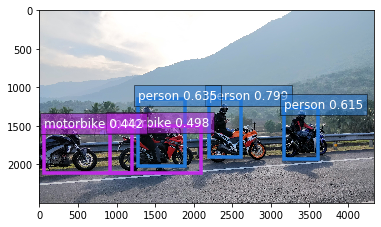

In [32]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.20

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

## Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [ ]:
sagemaker.Session().delete_endpoint(object_detector.endpoint_name)